Observação inicial: o dataset original possuia uma váriavel alvo chamada "enrolled" para alunos que se mantiveram no curso após o ano de graduação. Eu removi essa variável pois o meu objetivo neste caso é prever alunos que desistiram ou se graduaram do curso.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = '/content/data.csv'

df = pd.read_csv(path, sep=';')


exploração inicial

In [2]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
df['Mother\'s qualification'].value_counts()

,count
Mother's qualification,
1,1069
37,1009
19,953
38,562
3,438
34,130
2,83
4,49
12,42


Numa primeira exploração, os dois gráficos abaixo mostram uma relação de dropout dos alunos em seus cursos com notas baixas tiradas

<Axes: xlabel='Target', ylabel='Curricular units 2nd sem (grade)'>

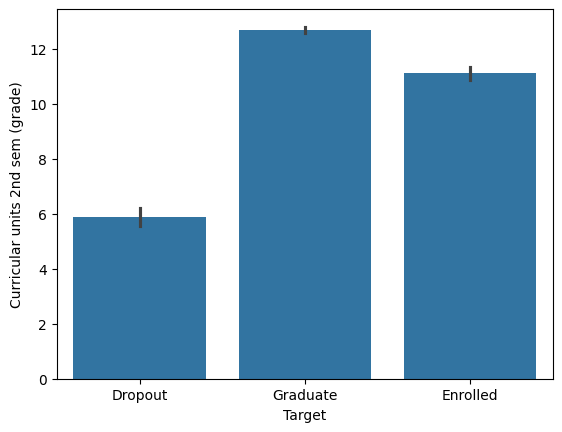

In [4]:
dropout_df = df[df['Target'] == 'Dropout']

sns.barplot(data=df, x='Target',y='Curricular units 2nd sem (grade)')


<Axes: xlabel='Target', ylabel='Curricular units 1st sem (grade)'>

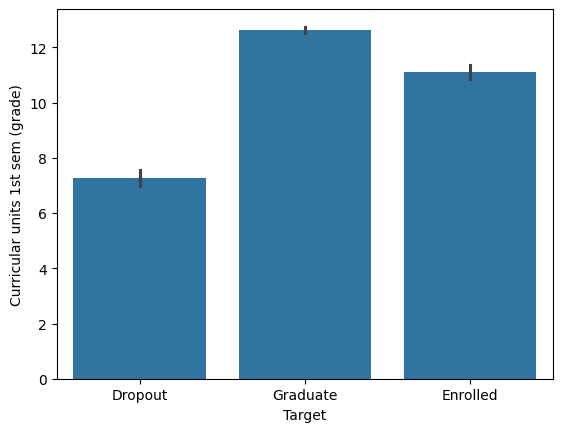

In [5]:
dropout_df = df[df['Target'] == 'Dropout']

sns.barplot(data=df, x='Target',y='Curricular units 1st sem (grade)')


No processo de decisão de inclusão de variáveis para o treinamento decidi que aquelas com valores categoricos muito discrepantes em relação às demais não deveriam ser inclusas. ex: Nacionalidade - Português(apenas 1 instancia), Americano(4000 instancias).

Como a variável "Nacionalidade" possui discrepância nas categorias estrangeiras e na outra variável "Tipo de ingresso" existe a categoria "estudante internacional", decidi que seria melhor deixar apenas segunda, pois além de tudo manter as duas seria redundante.

aqui dropo outras variaveis que não agregaram no desempenho do modelo

In [6]:
variables_to_drop = ["Marital status","Nacionality","Mother's occupation",
                     "Educational special needs","Father's occupation","Previous qualification",
                     "Application order","Previous qualification","Age at enrollment","Gender",
                     "Displaced","Application mode","Daytime/evening attendance\t","International",
                      "Curricular units 2nd sem (without evaluations)", "Debtor"]


dropando variaveis redundantes, fracas, e discrepantes.

In [7]:
df.drop(columns=variables_to_drop,inplace=True)

In [8]:
df_filtered = df[df['Target'] != 'Enrolled'].copy()

Definindo o que serão os dados de treino e teste e encodando o Target

Aqui tem um ponto crucial: o modelo pode estar tendo informações que não deveria com os dados dos alunos do 2o semestre, que desistiram no 1o. Ou seja dado que eles já desistiram no 1o semestre, os dados produzidos posteriormente poderão dar pistas ao modelo de que aqueles alunos deram Dropout. Por isso, removi as variaveis que remetem ao 2o semestre.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


y = df_filtered['Target']
X = df_filtered.drop(columns='Target')

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

eis um grafico que mostra a consequência dos alunos que já desistiram do curso no 1o semestre: há um número considerável de notas zero no segundo semestre.

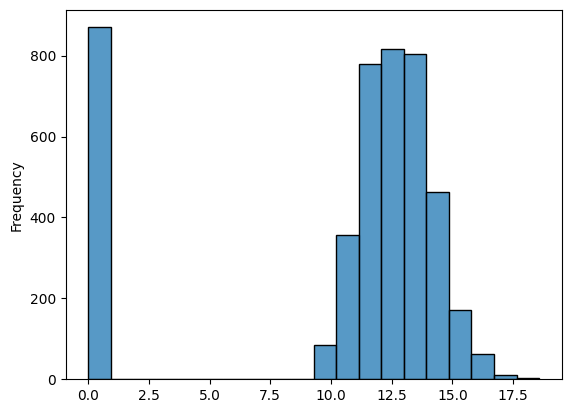

In [10]:
sns.histplot(df['Curricular units 2nd sem (grade)'], bins=20)
plt.xlabel('')
plt.ylabel('Frequency')
plt.show()

fazendo feature engineering:

1.taxa de aprovação do semetre = N de materias aprovadas / N materias matriculadas. No primeiro e segundo semestres

2.Delta da taxa de aprovação do 2o semestre em relação as do 1o semestre = tx aprv 2o semestre - tx aprv 1o semestre.

In [11]:
X['First sem approval rate'] = X['Curricular units 1st sem (approved)'] / (X['Curricular units 1st sem (enrolled)'] + 1e-6)


segmento as areas dos cursos em partes menores.

In [12]:
course_category_map = {
    171: 0, 9070: 0, 9670: 0, 9773: 0,  # Comunicação e Design
    8014: 1, 9238: 1, 9853: 1,          # Serviço Social / Educação
    9003: 2, 9147: 2, 9254: 2, 9991: 2, # Gestão / Administração
    9085: 3, 9500: 3, 9556: 3,          # Saúde
    33: 4, 9119: 4,                     # Tecnologia
    9130: 5                            # Outros (específico demais)
}

X['course_category'] = X['Course'].map(course_category_map)

varivel dizendo as materias com desistência ou reprovação

In [13]:
X['materias_reprovadas_1sem'] = X['Curricular units 1st sem (enrolled)'] - X['Curricular units 1st sem (approved)']
X['materias_reprovadas_2sem'] = X['Curricular units 2nd sem (enrolled)'] - X['Curricular units 2nd sem (approved)']

esplitando o dataset em treino teste e validação de forma estratificada

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Tamanho do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_val.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")



Tamanho do conjunto de treinamento: (2541, 25)
Tamanho do conjunto de validação: (544, 25)
Tamanho do conjunto de teste: (545, 25)


In [15]:
print("Columns in X_train:", X_train.columns.tolist())


Columns in X_train: ['Course', 'Previous qualification (grade)', "Mother's qualification", "Father's qualification", 'Admission grade', 'Tuition fees up to date', 'Scholarship holder', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP', 'First sem approval rate', 'course_category', 'materias_reprovadas_1sem', 'materias_reprovadas_2sem']


função para eliminar outliers atraves do limite interquartil

In [16]:
X_treated = X.copy()

def treat_outliers_iqr(X_treated, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X_treated[column] = np.clip(X_treated[column], lower_bound, upper_bound)

    return X_treated


eliminando os outliers da variavel "numero de avaliações", onde numeros altos demais não sao representatios.

In [17]:
X_treated = treat_outliers_iqr(X_treated, 'Curricular units 1st sem (evaluations)')

X_treated = treat_outliers_iqr(X_treated, 'Curricular units 2nd sem (evaluations)')


definindo variaveis continuas e discretas

In [18]:
continuous_var = ['Previous qualification (grade)','Admission grade','Unemployment rate',
               'Inflation rate','GDP', 'Curricular units 1st sem (evaluations)',
               'Curricular units 1st sem (grade)','First sem approval rate',
               'First sem approval rate'
                ]


In [19]:
discrete_var = ['Tuition fees up to date','Scholarship holder','course_category']


aplicando um preprocessador para preprocessamento das variaveis selecionadas

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_var),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), discrete_var)
    ])

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
])

transformando os dados de treinamento e inicializando um modelo de random forests.

também, aplicando smote para tratar as classes enrolled e dropout, que estão desbalanceadas em relação a graduate

In [21]:
df_filtered['Target'].value_counts()

,count
Target,
Graduate,2209
Dropout,1421


In [22]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from collections import Counter

param_distributions = {
    'n_estimators': randint(100, 130),
    'max_depth': randint(5, 10),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 15),
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}
preprocessor.fit(X_train)


X_train_transformed = preprocessor.transform(X_train)

original_counts = Counter(y_train)
print(f"Original dataset shape %s" % original_counts)

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train_transformed, y_train)

X_test_transformed = preprocessor.transform(X_test)

resampled_counts = Counter(y_train_res)
print(f"Resampled dataset shape %s" % resampled_counts)



Original dataset shape Counter({np.int64(1): 1546, np.int64(0): 995})
Resampled dataset shape Counter({np.int64(1): 1546, np.int64(0): 1546})


tamanho das classes do data set original: 1546 - graduate, 994 - dropout, 556 - enrolled.

tamanho das classes após o Counter do smote: 1546 - todas as classes.

o smote foi aplicado nos dados de treino.

no codigo abaixo é finalizado o smote e inicializado um processo de randomized search, para achar o modelo com os parametros que obtiveram o melhor resultado.

---





a ultima parte deste codigo "feature importances" capta os nomes das variaveis, adquire suas importancias em relação ao modelo e depois faz um gráfico de barras que mostra os valores das importancias de cada variavel.


Number of synthetic samples created by SMOTE:
  Class 1: No synthetic samples created (or undersampled, though SMOTE is oversampling)
  Class 0: 551 synthetic samples created

Best parameters found: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 121}
Best cross-validation accuracy: 0.8730

Feature Importances (Sorted):
num__First sem approval rate                   0.283701
num__First sem approval rate                   0.250168
num__Curricular units 1st sem (grade)          0.100955
cat_onehot__Tuition fees up to date_1          0.067134
cat_onehot__Tuition fees up to date_0          0.060490
cat_onehot__Scholarship holder_1               0.033393
num__Curricular units 1st sem (evaluations)    0.031482
cat_onehot__Scholarship holder_0               0.025009
num__Admission grade                           0.024478
cat_onehot__course_category_0                  0.022446
num__Previous qualification (grade)      

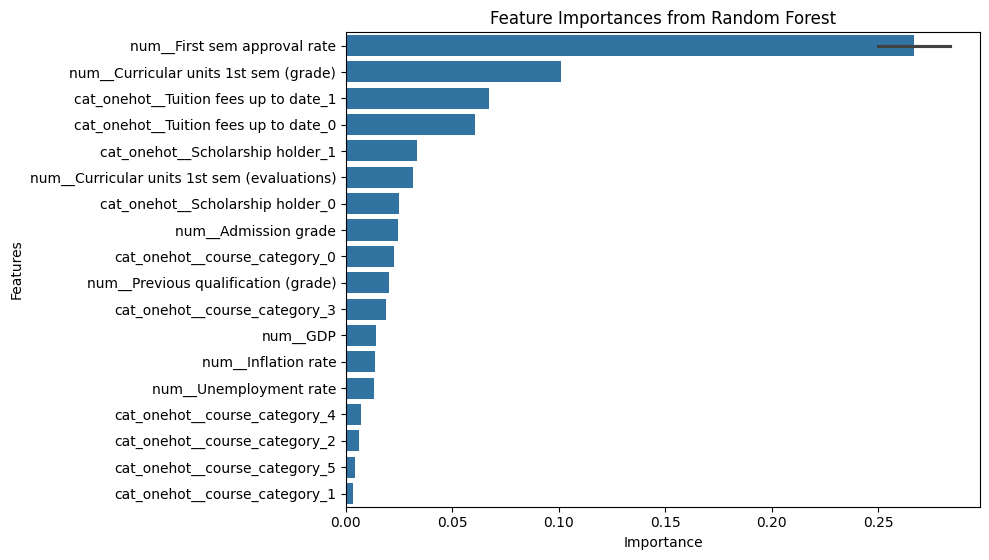

In [23]:
print("\nNumber of synthetic samples created by SMOTE:")
majority_class_count = max(original_counts.values())

for class_label, original_count in original_counts.items():
    resampled_count = resampled_counts[class_label]
    if resampled_count > original_count:
        synthetic_samples = resampled_count - original_count
        print(f"  Class {class_label}: {synthetic_samples} synthetic samples created")
    else:
         print(f"  Class {class_label}: No synthetic samples created (or undersampled, though SMOTE is oversampling)")


random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), # Create a new instance for RandomizedSearchCV
    param_distributions=param_distributions,
    n_iter=15,
    cv=2,
    scoring='f1_macro',
    random_state=42
)

# Realiza o random search nos dados de treinamento rebalanceados e TRANSFORMADOS
random_search.fit(X_train_res, y_train_res)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"\nBest parameters found: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

# O melhor modelo encontrado
best_rf_model = random_search.best_estimator_

# --- Get Feature Importances ---

feature_importances = best_rf_model.feature_importances_

try:

    if hasattr(preprocessor, 'get_feature_names_out'):

        feature_names_transformed = preprocessor.get_feature_names_out()

    elif hasattr(preprocessor, 'get_feature_names'):

         feature_names_transformed = preprocessor.get_feature_names(input_features=X_train.columns) # Use original column names
    else:
        print("Warning: Could not automatically get transformed feature names. Listing by index.")

        feature_names_transformed = [f"feature_{i}" for i in range(X_train_res.shape[1])]

except Exception as e:
     print(f"Error getting transformed feature names: {e}")
     feature_names_transformed = [f"feature_{i}" for i in range(X_train_res.shape[1])]


feature_importance_series = pd.Series(feature_importances, index=feature_names_transformed)

sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

print("\nFeature Importances (Sorted):")
print(sorted_feature_importance)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, min(len(sorted_feature_importance) * 0.3, 20))) # Limit plot height
sns.barplot(x=sorted_feature_importance.values, y=sorted_feature_importance.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


sobre as variaveis mais importantes, alguns insights: as mais importantes envolveram desempenho academico, como resultado de notas, notas de qualificações anteriores, nota da admissão do curso etc. E, fatores financeiros, como se o pagamento do curso está em dia ou não. A segunda maior variavel foi a media das notas do segundo semestre de cada aluno. De acordo com o gráfico esse é um forte indicador, e para mim, seria um indicador forte de desistência futura ou graduação.

aqui o random forests faz suas previsões. usei metricas de precision, recall e f1-score para cada classe do target

In [24]:

y_pred_test = best_rf_model.predict(X_test_transformed)

# Evaluate the metrics on the original y_test
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"\nAccuracy of the best model on the Test Set: {accuracy_test}")

precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(y_test, y_pred_test, average=None)

for i, label in enumerate(label_encoder.classes_):
    print(f"Metrics for class '{label}' (Best Model - Test Set):")
    print(f"  Precision: {precision_test[i]:.4f}")
    print(f"  Recall: {recall_test[i]:.4f}")
    print(f"  F1-score: {fscore_test[i]:.4f}")
    print(f"  Support: {support_test[i]}")

y_pred_train_orig = best_rf_model.predict(X_train_transformed)
accuracy_train_orig = accuracy_score(y_train, y_pred_train_orig)
print(f"Accuracy of the best model on the Original Training Set: {accuracy_train_orig}")


Accuracy of the best model on the Test Set: 0.8752293577981651
Metrics for class 'Dropout' (Best Model - Test Set):
  Precision: 0.8643
  Recall: 0.8075
  F1-score: 0.8350
  Support: 213
Metrics for class 'Graduate' (Best Model - Test Set):
  Precision: 0.8815
  Recall: 0.9187
  F1-score: 0.8997
  Support: 332
Accuracy of the best model on the Original Training Set: 0.9138134592680047
